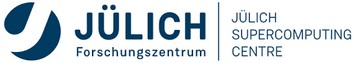
Author: [Jens Henrik Göbbert](mailto:j.goebbert@fz-juelich.de)
------------------------------------

### Jupyter-JSC under the hood

UNICORE creates a `job-directory at $SCRATCH/<project_name>/<hash>` for configuration and log files.  
The path is exported as `$JUPYTER_LOG_DIR`.

Let's examine that directory.

---------------------------------------------

In [1]:
echo $JUPYTER_LOG_DIR

/p/scratch/ccstdl/unicore-jobs/cc26c409-62b1-4c5d-84b4-850b5c4790c4


In [5]:
ls -la $JUPYTER_LOG_DIR

total 16503
drwx--S---   2 goebbert1 ccstdl 16384 Mar 14 14:27 .
drwxrwsr-x 107 jitsev1   ccstdl 32768 Mar 14 14:26 ..
-rw-------   1 goebbert1 ccstdl  1381 Mar 14 14:27 config.py
-rw-------   1 goebbert1 ccstdl    32 Mar 14 14:26 .jupyter.token
-rw-------   1 goebbert1 ccstdl  2318 Mar 14 14:26 notebooks-ca_trust.crt
-rw-------   1 goebbert1 ccstdl   137 Mar 14 14:26 .oauth.scopes
-rw-------   1 goebbert1 ccstdl  2319 Mar 14 14:26 service_ca.crt
-rw-------   1 goebbert1 ccstdl  2155 Mar 14 14:26 service_cert.crt
-rw-------   1 goebbert1 ccstdl  1704 Mar 14 14:26 service_cert.key
-rw-------   1 goebbert1 ccstdl     6 Mar 14 14:27 service.pid
-rw-------   1 goebbert1 ccstdl 15444 Mar 14 14:26 start.sh
-rw-------   1 goebbert1 ccstdl 48213 Mar 14 17:32 stderr
-rw-------   1 goebbert1 ccstdl  3620 Mar 14 17:32 stdout
-rw-------   1 goebbert1 ccstdl  1050 Mar 14 14:26 stop.sh
-rw-------   1 goebbert1 ccstdl     6 Mar 14 14:26 UNICORE_SCRIPT_PID
-rw-------   1 goebbert1 ccstdl     6 Mar 14 

In [3]:
cat $JUPYTER_LOG_DIR/start.sh

#!/bin/bash

# Catch SIGTERM signal and stop $child process
_term() {
  echo "$(date) - Stop JupyterLab ..."
  if [[ -z $child ]]; then
    echo "$(date) - Stop JupyterLab - unknown PID. Start stop.sh to wait for PID"
    bash ${DIR}/stop.sh &
  else
    pkill --parent $child
    kill $child
    echo "$(date) - Stop JupyterLab ( $child ) ... done"
    if [[ -z $token_pid ]]; then
      echo "$(date) - Validate Token PID not found..."
    else
      echo "$(date) - Stop Validate Token Script ( $token_pid ) ..."
      kill $token_pid
      echo "$(date) - Stop Validate Token Script ( $token_pid ) ... done"
    fi
  fi
}
trap _term SIGTERM

# show user a message in the UI
send_spawn_update () {
  PERCENTAGE=$1
  SUMMARY=$2
  DETAILS=$3
  curl -s ${CURL_ARGS} -H "Authorization: token ${JUPYTERHUB_API_TOKEN}" -H "Content-Type: application/json" -d '{"progress": '"${PERCENTAGE}"', "failed": false, "html_message": "<details><summary>'"${SUMMARY}"'</summary><p>'"${DETAILS}"'</p></details>"}' -

In [ ]:
cat $JUPYTER_LOG_DIR/stderr

## Customizing the start procedure

```python
# Load modules
load_modules () {
  echo "$(date) - Load modules ..."
  if [[ -f ${HOME}/.jupyter/start_jupyter-jsc.sh ]]; then
    send_spawn_update_warning 70 "Load customized modules ..." "You're using a customized modules script, defined in ${HOME}/.jupyter/start_jupyter-jsc.sh."
    echo "------ start_jupyter-jsc.sh file ------"
    cat ${HOME}/.jupyter/start_jupyter-jsc.sh
    echo "------ start_jupyter-jsc.sh file ------"
    source ${HOME}/.jupyter/start_jupyter-jsc.sh
    send_spawn_update_warning 80 "Load customized modules done" "You're using a customized modules script, defined in ${HOME}/.jupyter/start_jupyter-jsc.sh."
  else
    send_spawn_update 70 "Load default modules ..." "Loading Jupyter/2022.3.4 in Stages/2022."
    
    module purge
    module load Stages/2022 GCCcore/.11.2.0 Python Jupyter/2022.3.4

    if [[ $JUPYTER_MODULE_BASH_ENABLED -eq 1 ]]; then
      module load JupyterKernel-Bash/.0.7.2-2022.3.4 
    fi
    if [[ $JUPYTER_MODULE_CLING_ENABLED -eq 1 ]]; then
      module load JupyterKernel-Cling/.0.9-2022.3.4
    fi
    if [[ $JUPYTER_MODULE_JAVASCRIPT_ENABLED -eq 1 ]]; then
      module load JupyterKernel-JavaScript/.5.2.1-2022.3.4 
    fi
    if [[ $JUPYTER_MODULE_JULIA_ENABLED -eq 1 ]]; then
      module load JupyterKernel-Julia/.1.7.1-2022.3.4 
    fi
    
    <..>
```

#### Load customized modules ...
```
    if [[ -f ${HOME}/.jupyter/start_jupyter-jsc.sh ]]; then
       <..>
       source ${HOME}/.jupyter/start_jupyter-jsc.sh
```

```python
start () {
  echo "$(date) - Start jupyterhub-singleuser ..."
  export JUPYTERHUB_HOME=${JUPYTERHUB_HOME:-${HOME}}
  cd ${JUPYTERHUB_HOME}

  if [[ -n $JUPYTERJSC_USER_CMD ]]; thenif [[ $JUPYTER_MODULE_BASH_ENABLED -eq 1 ]]; then
      module load JupyterKernel-Bash/.0.7.2-2022.3.4 
    fi
    if [[ $JUPYTER_MODULE_CLING_ENABLED -eq 1 ]]; then
      module load JupyterKernel-Cling/.0.9-2022.3.4
    fi
    if [[ $JUPYTER_MODULE_JAVASCRIPT_ENABLED -eq 1 ]]; then
      module load JupyterKernel-JavaScript/.5.2.1-2022.3.4 
    fi
    if [[ $JUPYTER_MODULE_JULIA_ENABLED -eq 1 ]]; then
      module load JupyterKernel-Julia/.1.7.1-2022.3.4 
    fi
    send_spawn_update_warning 95 "Start JupyterLab with custom command" "Use custom command \$JUPYTERJSC_USER_CMD . You will be redirected, when your JupyterLab is ready."
    timeout 30d ${JUPYTERJSC_USER_CMD} ${JUPYTERJSC_CMD_ARGS} &
    child=$!
  elif [[ -n $JUPYTERJSC_USER_CMD_ARGS ]]; then
    send_spawn_update_warning 95 "Start JupyterLab with custom arguments" "Use custom arguments \$JUPYTERJSC_USER_CMD_ARGS . You will be redirected, when your JupyterLab is ready."
    timeout 30d jupyterhub-singleuser --config ${DIR}/config.py ${JUPYTERJSC_CMD_ARGS} ${JUPYTERJSC_USER_CMD_ARGS} &
    child=$!
  else
    send_spawn_update 95 "Start JupyterLab" "You will be redirected, when your JupyterLab is ready."
    timeout 30d jupyterhub-singleuser --config ${DIR}/config.py ${JUPYTERJSC_CMD_ARGS} &
    child=$!
  fi
  echo "$child" > ${PID_PATH}
  echo "$(date) - Start jupyterhub-singleuser done (PID: $child )"

  echo "$(date) - Start validate_token.sh ..."
  /bin/bash ${DIR}/validate_token.sh ${child} ${JUPYTERHUB_API_URL} &
  token_pid=$!
  echo "$token_pid" > ${VALIDATE_TOKEN_PID_PATH}
  echo "$(date) - Start validate_token.sh done (PID: $token_pid )"

  wait $child
}
```

```timeout 30d jupyterhub-singleuser --config ${DIR}/config.py ${JUPYTERJSC_CMD_ARGS} &```

#### Start JupyterLab with custom command
```JupyterLab gets started by `timeout 30d ${JUPYTERJSC_USER_CMD} ${JUPYTERJSC_CMD_ARGS} &```

#### Start JupyterLab with custom arguments
```timeout 30d jupyterhub-singleuser --config ${DIR}/config.py ${JUPYTERJSC_CMD_ARGS} ${JUPYTERJSC_USER_CMD_ARGS} &```

